In [0]:
import numpy as np
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import backend as K

In [13]:
#Start with 4-PAM - n=1, k=2
n = 1
k = 2
M = 2**k
R = k/n
training_noise_ratio = 10**0.7
noise_mag = np.sqrt(1/(2*R*training_noise_ratio))
print(noise_mag)

0.22334179607548157


In [14]:
dat_size=M*10000
rand_data=np.random.randint(M,size=dat_size)
xs = keras.utils.to_categorical(rand_data)
print('verification checks:')
print(xs[2],'\n',xs[20],'\n',xs[200])


verification checks:
[1. 0. 0. 0.] 
 [0. 0. 0. 1.] 
 [0. 0. 1. 0.]


In [15]:
#input
autoenc_in = keras.layers.Input(shape=(M,))
#encoder
encoder_0 = keras.layers.Dense(M,activation='relu')(autoenc_in)
encoder_1 = keras.layers.Dense(n,activation='linear')(encoder_0)
#Regulariser
regulariser = keras.layers.BatchNormalization(center=False,scale=False)(encoder_1)
#Channel
channel = keras.layers.GaussianNoise(noise_mag)(regulariser)
#Squaring for energy detection
presquaring = keras.layers.Lambda(lambda x: K.square(x))(channel)
#decoder
decoder_0 = keras.layers.Dense(M,activation='relu')(presquaring)
decoder_1 = keras.layers.Dense(M,activation='softmax')(decoder_0)
#whole model
autoenc = keras.models.Model(autoenc_in,decoder_1)
print (autoenc.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1)                 2         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 1)                 0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 8   

In [0]:
#learning rate and compiling
adam = keras.optimizers.Adam(learning_rate=0.0003)
autoenc.compile(optimizer=adam, loss='categorical_crossentropy')

In [17]:
autoenc.fit(xs,xs,batch_size=M*100,epochs=250)

Epoch 1/250
100/100 [==============================] - 0s 1ms/step - loss: 1.7955
Epoch 2/250
100/100 [==============================] - 0s 1ms/step - loss: 1.6242
Epoch 3/250
100/100 [==============================] - 0s 1ms/step - loss: 1.4973
Epoch 4/250
100/100 [==============================] - 0s 1ms/step - loss: 1.3883
Epoch 5/250
100/100 [==============================] - 0s 1ms/step - loss: 1.2979
Epoch 6/250
100/100 [==============================] - 0s 1ms/step - loss: 1.2235
Epoch 7/250
100/100 [==============================] - 0s 1ms/step - loss: 1.1618
Epoch 8/250
100/100 [==============================] - 0s 1ms/step - loss: 1.1116
Epoch 9/250
100/100 [==============================] - 0s 1ms/step - loss: 1.0737
Epoch 10/250
100/100 [==============================] - 0s 1ms/step - loss: 1.0457
Epoch 11/250
100/100 [==============================] - 0s 1ms/step - loss: 1.0245
Epoch 12/250
100/100 [==============================] - 0s 1ms/step - loss: 1.0103
Epoch 13/250


In [18]:
#define sub-models with identical parameters:
encoder = keras.models.Model(autoenc_in,regulariser)
print(encoder.summary())
deco_in = keras.layers.Input(shape=(n,))
#Decoder must include presquaring
deco = autoenc.layers[-3](deco_in)
deco = autoenc.layers[-2](deco)
deco = autoenc.layers[-1](deco)
decoder = keras.models.Model(deco_in,deco)
print(decoder.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 20        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 5         
_________________________________________________________________
batch_normalization_1 (Batch (None, 1)                 2         
Total params: 27
Trainable params: 25
Non-trainable params: 2
_________________________________________________________________
None
Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1)]               0         
_________________________________________

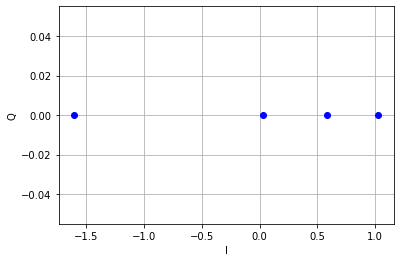

In [19]:
#Plot the encoder's points, squared
data = []
for i in range(0,M):
  temp = np.zeros(M)
  temp[i] = 1
  data.append(encoder.predict(np.expand_dims(temp,axis=0)))
data = np.array(data)
#Change to 1D, square
#data = np.square(np.squeeze(data))
data = np.squeeze(data)
plt.plot(data,np.zeros(M),'bo')
plt.grid()
plt.xlabel('I')
plt.ylabel('Q')
plt.show()

In [20]:
#Calculate expected power usage (for equal usage of each symbol)
power_use=0
for iter1 in np.arange(M):
    symbol_energy=data[iter1]**2
    print("symbol X:",data[iter1],"\n symbol energy=",symbol_energy)
    power_use += symbol_energy/M
print(power_use)
scaling=np.sqrt(power_use)

symbol X: 0.026007017 
 symbol energy= 0.0006763649395173689
symbol X: 1.0283473 
 symbol energy= 1.0574980743968467
symbol X: -1.6077931 
 symbol energy= 2.5849986290227775
symbol X: 0.58077425 
 symbol energy= 0.3372987267291627
0.995117948772076


In [21]:
#Plot error rate
EbNo_range_dB = list(np.arange(0,16,1.5))
ber= [None]*len(EbNo_range_dB)
for iter1 in range(len(EbNo_range_dB)):
    EbNo = 10**(EbNo_range_dB[iter1]/10.0)
    noise_std = np.sqrt(1/(2*R*EbNo))
    noise = noise_std*np.random.randn(dat_size,n)
    sig_in = encoder.predict(xs) + noise
    prediction = decoder.predict(sig_in)
    prediction = np.argmax(prediction,axis=1)
    wrong = (prediction != rand_data)
    count = np.sum(wrong)
    ber[iter1] = count/dat_size
    print('EbNo(dB):',EbNo_range_dB[iter1],'SER',ber[iter1])


EbNo(dB): 0.0 SER 0.491725
EbNo(dB): 1.5 SER 0.442575
EbNo(dB): 3.0 SER 0.380825
EbNo(dB): 4.5 SER 0.3107
EbNo(dB): 6.0 SER 0.24385
EbNo(dB): 7.5 SER 0.17765
EbNo(dB): 9.0 SER 0.1211
EbNo(dB): 10.5 SER 0.07515
EbNo(dB): 12.0 SER 0.04095
EbNo(dB): 13.5 SER 0.019725
EbNo(dB): 15.0 SER 0.008225
